In [3]:
#download colon cancer dataset
!gdown --id 1lJyMNhxVcTL7SCP6NuR5Aneph33eaSFP

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1lJyMNhxVcTL7SCP6NuR5Aneph33eaSFP
To: /content/colon_image_set.rar
100% 962M/962M [00:10<00:00, 95.1MB/s]


In [ ]:
!unrar x "/content/colon_image_set.rar"

In [5]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

In [6]:
normal = glob('/content/colon_image_set/colon_image_sets/colon_n/*.jpeg')
affected = glob('/content/colon_image_set/colon_image_sets/colon_aca/*.jpeg')
trainpath=normal[:int(len(normal)*0.7)]+affected[:int(len(normal)*0.7)]
testpath=normal[int(len(normal)*0.7):]+affected[int(len(normal)*0.7):]
from random import shuffle, seed; seed(10);
shuffle(trainpath)
shuffle(testpath)

In [ ]:
targetslabels={'colon_n':0,'colon_aca':1}
class colondataset(Dataset):
 def __init__(self,path):
  self.fpaths=path
  self.normalize = transforms.Normalize(mean=[0.485,
  0.456, 0.406],std=[0.229, 0.224, 0.225])
  from random import shuffle, seed; seed(10);
  shuffle(self.fpaths)
  self.targets =[targetslabels[fpath.split('/')[-2]] for fpath in self.fpaths]
 def __len__(self): return len(self.fpaths)
 def __getitem__(self, ix):
  f = self.fpaths[ix]
  target = self.targets[ix]
  im = (cv2.imread(f)[:,:,::-1])
  im = cv2.resize(im, (224,224))
  im = torch.tensor(im/255)
  im = im.permute(2,0,1)
  im = self.normalize(im)
  return im.float().to(device),torch.tensor([target]).float().to(device)
def get_data():
  traindataset = colondataset(trainpath)
  trn_dl = DataLoader(traindataset, batch_size=32, shuffle=True, \
  drop_last = True)
  testataset = colondataset(testpath)
  val_dl = DataLoader(testataset, batch_size=32, shuffle=True, \
  drop_last = True)
  return trn_dl, val_dl

In [ ]:
from torchsummary import summary
def build_model():
  model = models.vgg16(pretrained=True).to(device)
  for param in model.parameters():
    param.requires_grad = False
  model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
  model.classifier = nn.Sequential(nn.Flatten(),nn.Linear(512, 128),nn.ReLU(),nn.Dropout(0.2),nn.Linear(128, 1),nn.Sigmoid())
  loss_fn = nn.BCELoss()
  optimizer = torch.optim.SGD(model.parameters(),lr= 1e-3)
  return model.to(device), loss_fn, optimizer
def train_batch(x, y, model, optimizer, loss_fn):
  model.train()
  prediction = model(x)
  batch_loss = loss_fn(prediction, y)
  batch_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return batch_loss.item()
def accuracy(x, y, model):
  model.eval()
  prediction = model(x)
  is_correct = (prediction > 0.5) == y
  return is_correct.cpu().numpy().tolist()


In [ ]:
import tqdm
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = build_model()
summary(model,(3,224,224))
train_losses, train_accuracies = [], []
val_accuracies = []
for epoch in range(10):
  print(f" epoch {epoch + 1}/10")
  train_epoch_losses, train_epoch_accuracies = [], []
  val_epoch_accuracies = []
  for ix, batch in enumerate(tqdm.tqdm(iter(trn_dl))):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, \
    loss_fn)
    train_epoch_losses.append(batch_loss)
  train_epoch_loss = np.array(train_epoch_losses).mean()
  print("caalculate train acc...")
  for ix, batch in enumerate(tqdm.tqdm(iter(trn_dl))):
    x, y = batch
    is_correct = accuracy(x, y, model)
    train_epoch_accuracies.extend(is_correct)
  train_epoch_accuracy = np.mean(train_epoch_accuracies)
  print("caalculate val acc...")
  for ix, batch in enumerate(tqdm.tqdm(iter(val_dl))):
    x, y = batch
    val_is_correct = accuracy(x, y, model)
    val_epoch_accuracies.extend(val_is_correct)
  val_epoch_accuracy = np.mean(val_epoch_accuracies)
  train_losses.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  val_accuracies.append(val_epoch_accuracy)
  print("train_acc: %2.2f%% val_acc: %2.2f%%" %(train_epoch_accuracy*100,val_epoch_accuracy*100))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

100%|██████████| 218/218 [02:20<00:00,  1.55it/s]


caalculate train acc...


100%|██████████| 218/218 [02:14<00:00,  1.62it/s]


caalculate val acc...


100%|██████████| 93/93 [00:56<00:00,  1.65it/s]


train_acc: 66.28% val_acc: 67.14%
 epoch 2/10


100%|██████████| 218/218 [02:12<00:00,  1.64it/s]


caalculate train acc...


100%|██████████| 218/218 [02:12<00:00,  1.64it/s]


caalculate val acc...


100%|██████████| 93/93 [00:55<00:00,  1.66it/s]


train_acc: 87.64% val_acc: 87.00%
 epoch 3/10


100%|██████████| 218/218 [02:11<00:00,  1.66it/s]


caalculate train acc...


100%|██████████| 218/218 [02:11<00:00,  1.66it/s]


caalculate val acc...


100%|██████████| 93/93 [00:55<00:00,  1.66it/s]


train_acc: 94.32% val_acc: 94.19%
 epoch 4/10


100%|██████████| 218/218 [02:11<00:00,  1.66it/s]


caalculate train acc...


100%|██████████| 218/218 [02:10<00:00,  1.67it/s]


caalculate val acc...


100%|██████████| 93/93 [00:56<00:00,  1.65it/s]


train_acc: 94.93% val_acc: 95.03%
 epoch 5/10


100%|██████████| 218/218 [02:11<00:00,  1.66it/s]


caalculate train acc...


100%|██████████| 218/218 [02:11<00:00,  1.66it/s]


caalculate val acc...


100%|██████████| 93/93 [00:56<00:00,  1.64it/s]


train_acc: 95.26% val_acc: 95.43%
 epoch 6/10


100%|██████████| 218/218 [02:10<00:00,  1.67it/s]


caalculate train acc...


100%|██████████| 218/218 [02:10<00:00,  1.66it/s]


caalculate val acc...


100%|██████████| 93/93 [00:56<00:00,  1.66it/s]


train_acc: 95.36% val_acc: 95.73%
 epoch 7/10


100%|██████████| 218/218 [02:11<00:00,  1.65it/s]


caalculate train acc...


100%|██████████| 218/218 [02:11<00:00,  1.65it/s]


caalculate val acc...


100%|██████████| 93/93 [00:55<00:00,  1.67it/s]


train_acc: 95.50% val_acc: 95.77%
 epoch 8/10


100%|██████████| 218/218 [02:11<00:00,  1.66it/s]


caalculate train acc...


100%|██████████| 218/218 [02:11<00:00,  1.66it/s]


caalculate val acc...


100%|██████████| 93/93 [00:55<00:00,  1.67it/s]


train_acc: 95.46% val_acc: 95.70%
 epoch 9/10


100%|██████████| 218/218 [02:11<00:00,  1.66it/s]


caalculate train acc...


100%|██████████| 218/218 [02:10<00:00,  1.67it/s]


caalculate val acc...


100%|██████████| 93/93 [00:56<00:00,  1.65it/s]


train_acc: 95.54% val_acc: 95.87%
 epoch 10/10


100%|██████████| 218/218 [02:10<00:00,  1.67it/s]


caalculate train acc...


100%|██████████| 218/218 [02:10<00:00,  1.67it/s]


caalculate val acc...


100%|██████████| 93/93 [00:55<00:00,  1.67it/s]

train_acc: 95.69% val_acc: 95.87%


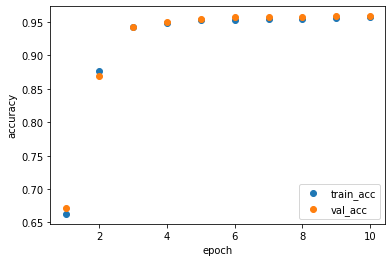

In [ ]:
epochs=[i+1 for i in range(0,10)]
plt.scatter(epochs,train_accuracies,label='train_acc')
plt.scatter(epochs,val_accuracies,label='val_acc')
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [ ]:
import pickle
with open('/content/coloncancerclassification.model','wb') as f:
  pickle.dump(model,f)
  f.close()
with open('/content/coloncancerclassificationCPU.model','wb') as f:
  pickle.dump(model.to('cpu'),f)
  f.close()

In [7]:
!gdown 1-5MqH1WZOQmWZKbb-rpkqJV3qOxroJ8H
!gdown 1FchizkInc-_N87Rmp4X26MIYHTNQfMm0
import pickle
if device=='cpu':
  with open('/content/coloncancerclassificationCPU.model','rb')as f:
    loaded_model=pickle.load(f)
    f.close()
else:
  with open('/content/coloncancerclassification.model','rb')as f:
    loaded_model=pickle.load(f)
    f.close()

Downloading...
From: https://drive.google.com/uc?id=1-5MqH1WZOQmWZKbb-rpkqJV3qOxroJ8H
To: /content/coloncancerclassification.model
100% 59.1M/59.1M [00:00<00:00, 312MB/s]
Downloading...
From: https://drive.google.com/uc?id=1FchizkInc-_N87Rmp4X26MIYHTNQfMm0
To: /content/coloncancerclassificationCPU.model
100% 59.1M/59.1M [00:00<00:00, 298MB/s]


In [9]:
labelstargets={0:'colon_n',1:'colon_aca'}
norm_upnorm={'colon_n':'normal','colon_aca':'upnormal'}
normalize = transforms.Normalize(mean=[0.485,
  0.456, 0.406],std=[0.229, 0.224, 0.225])
correcte=0
for i in (testpath):
  im = (cv2.imread(i)[:,:,::-1])
  im = cv2.resize(im, (224,224))
  im = torch.tensor(im/255)
  im = im.permute(2,0,1)
  im = normalize(im)
  target=i.split('/')[-2]
  pred=loaded_model(im.float().to(device)[None])
  if pred>=0.5:
    pred=1
  else:
    pred=0
  if target==labelstargets[pred]:
    correcte+=1
  print("actual: %s , predicted: %s"%(norm_upnorm[target],norm_upnorm[labelstargets[pred]]))
print("correct predictions on test set (%d image)= %d \ntotal accuracy= %2.2f%%"%(len(testpath),correcte,(correcte/len(testpath))*100))

actual: normal , predicted: normal
actual: upnormal , predicted: upnormal
actual: upnormal , predicted: upnormal
actual: normal , predicted: normal
actual: normal , predicted: normal
actual: normal , predicted: normal
actual: normal , predicted: normal
actual: upnormal , predicted: upnormal
actual: normal , predicted: normal
actual: upnormal , predicted: upnormal
actual: upnormal , predicted: upnormal
actual: upnormal , predicted: upnormal
actual: upnormal , predicted: normal
actual: normal , predicted: normal
actual: upnormal , predicted: upnormal
actual: normal , predicted: normal
actual: normal , predicted: normal
actual: normal , predicted: normal
actual: normal , predicted: normal
actual: normal , predicted: normal
actual: normal , predicted: normal
actual: normal , predicted: normal
actual: normal , predicted: normal
actual: upnormal , predicted: upnormal
actual: normal , predicted: normal
actual: normal , predicted: normal
actual: upnormal , predicted: upnormal
actual: normal , 